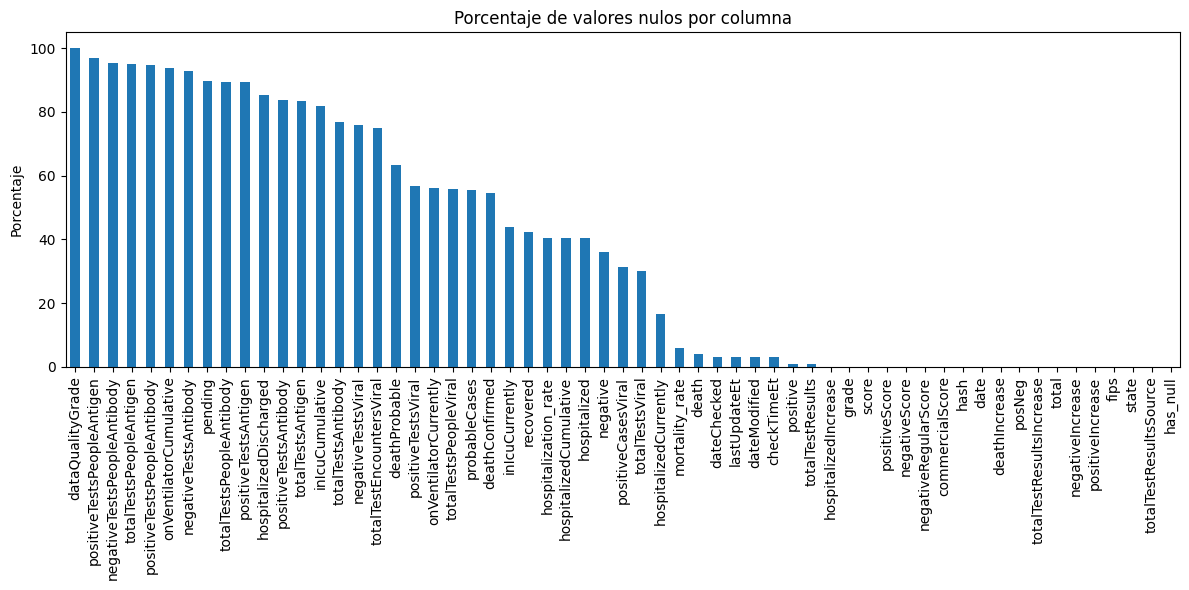

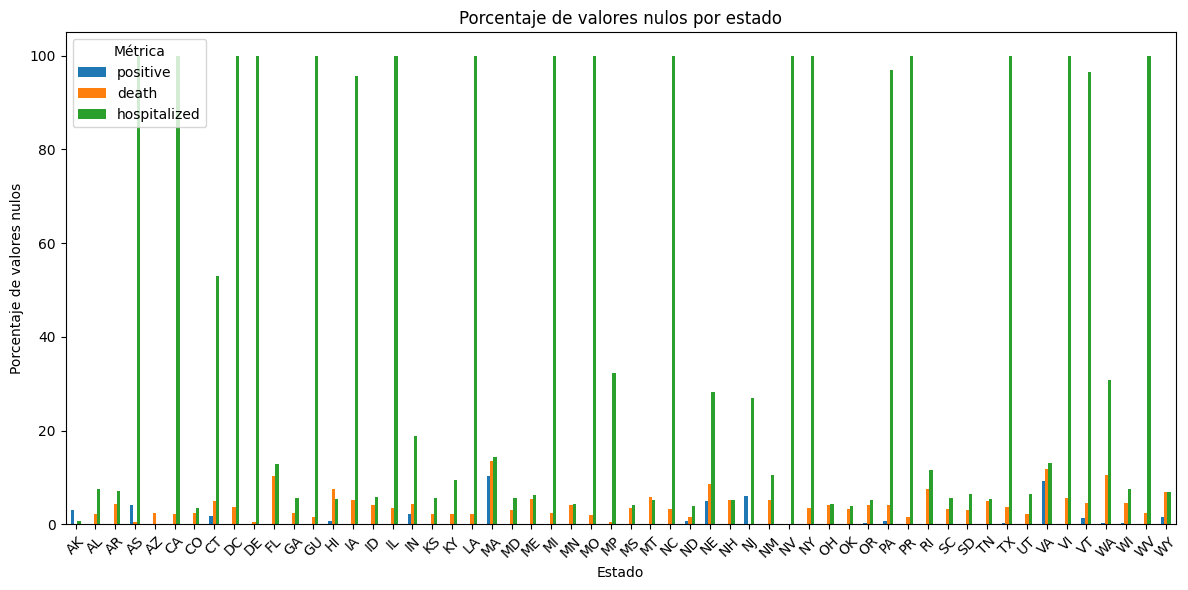

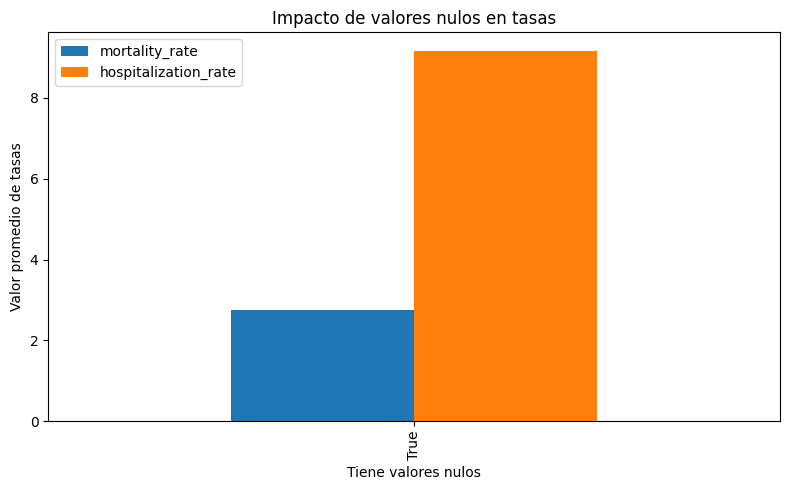

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from scipy import stats
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, HoverTool, ColorBar
from bokeh.transform import linear_cmap
from bokeh.palettes import Spectral10, RdYlBu11

url = 'https://api.covidtracking.com/v1/states/daily.json'
response = requests.get(url)
data = response.json()



def analisis_datos_nulos(df):
    # 1. Porcentaje de valores nulos por columna
    null_percentages = df.isnull().mean() * 100

    # 2. Evolución temporal de valores nulos
    null_evolution = df.groupby('date')['positive'].apply(lambda x: x.isnull().mean() * 100).reset_index(name='null_percentage')

    # 3. Correlación entre valores nulos
    null_cols = ['positive', 'death', 'hospitalized', 'inIcuCumulative']
    null_corr = df[null_cols].isnull().corr()

    # Ordenar la matriz de correlación
    sort_idx = null_corr.abs().sum(axis=1).argsort()[::-1]
    null_corr = null_corr.iloc[sort_idx, sort_idx]

    # 4. Impacto de valores nulos en métricas clave
    df['has_null'] = df.isnull().any(axis=1)
    metrics_comparison = df.groupby('has_null')[['positive', 'death', 'hospitalized']].mean()

    # 5. Distribución de valores nulos por estado
    null_by_state = df.groupby('state')[['positive', 'death', 'hospitalized']].apply(lambda x: x.isnull().mean() * 100).reset_index()

    # 6. Patrones de valores nulos
    null_patterns = df.isnull().sum(axis=1).value_counts().sort_index()

    # 7. Impacto en las tasas
    df['mortality_rate'] = df['death'] / df['positive'] * 100
    df['hospitalization_rate'] = df['hospitalized'] / df['positive'] * 100

    rate_comparison = df.groupby('has_null')[['mortality_rate', 'hospitalization_rate']].mean()

    return null_percentages, null_evolution, null_corr, metrics_comparison, null_by_state, null_patterns, rate_comparison

# Ejecutar el análisis de datos nulos
null_percentages, null_evolution, null_corr, metrics_comparison, null_by_state, null_patterns, rate_comparison = analisis_datos_nulos(df)

# Visualización de porcentaje de valores nulos por columna
plt.figure(figsize=(12, 6))
null_percentages.sort_values(ascending=False).plot(kind='bar')
plt.title('Porcentaje de valores nulos por columna')
plt.ylabel('Porcentaje')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Visualización de la evolución temporal de valores nulos
output_notebook()
p = figure(title="Evolución temporal de valores nulos", x_axis_type="datetime",
           x_axis_label="Fecha", y_axis_label="Porcentaje de valores nulos", width=800, height=400)
p.line('date', 'null_percentage', source=ColumnDataSource(null_evolution))
p.add_tools(HoverTool(tooltips=[("Fecha", "@date{%F}"), ("Porcentaje", "@null_percentage{0.2f}%")],
                     formatters={"@date": "datetime"}))
show(p)

# Visualización de la distribución de valores nulos por estado
fig, ax = plt.subplots(figsize=(12, 6))
null_by_state.plot(x='state', y=['positive', 'death', 'hospitalized'], kind='bar', ax=ax)
ax.set_title('Porcentaje de valores nulos por estado')
ax.set_xlabel('Estado')
ax.set_ylabel('Porcentaje de valores nulos')
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='upper left', title='Métrica')
plt.tight_layout()
plt.show()

# Visualización del impacto en tasas
fig, ax = plt.subplots(figsize=(8, 5))
rate_comparison.plot(kind='bar', ax=ax)
ax.set_title('Impacto de valores nulos en tasas')
ax.set_xlabel('Tiene valores nulos')
ax.set_ylabel('Valor promedio de tasas')
plt.tight_layout()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

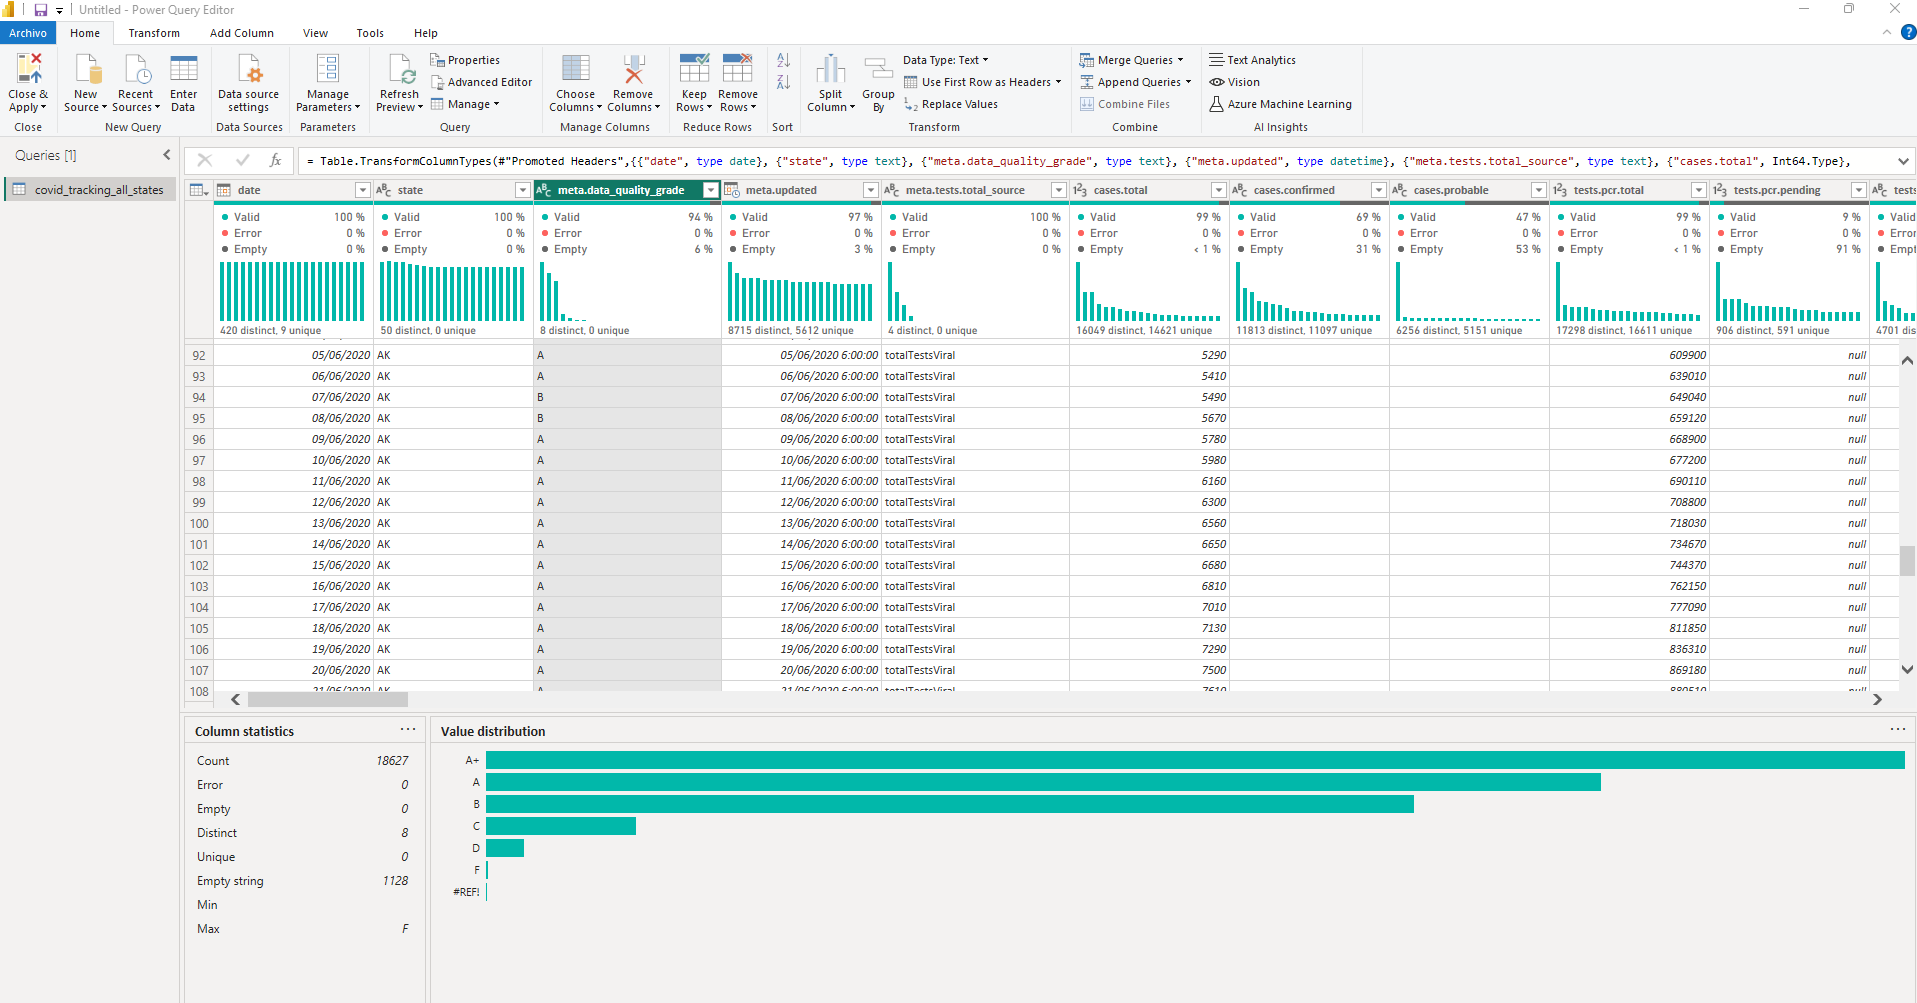

In [ ]:
import requests
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Obtener los datos de la API
url = "https://api.covidtracking.com/v1/states/daily.json"
response = requests.get(url)
data = response.json()

# Convertir a DataFrame
df = pd.DataFrame(data)

# Convertir la fecha a formato datetime
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

# Agregar columnas para mes y año
df['month'] = df['date'].dt.to_period('M')

# Cargar el diccionario de estados
states_dict = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
    'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
    'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa',
    'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri',
    'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey',
    'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio',
    'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
    'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont',
    'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'
}

# Reemplazar abreviaturas por nombres completos de estados
df['state'] = df['state'].map(states_dict)

# Agrupar por estado y mes, y calcular la suma de muertes y casos
monthly_data = df.groupby(['state', 'month']).agg({
    'deathIncrease': 'sum',
    'positiveIncrease': 'sum'
}).reset_index()

# Crear el gráfico
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1,
                    subplot_titles=('Muertes por COVID-19', 'Casos de COVID-19'))

for state in monthly_data['state'].unique():
    state_data = monthly_data[monthly_data['state'] == state]

    # Gráfico de muertes
    fig.add_trace(
        go.Scatter(x=state_data['month'].astype(str), y=state_data['deathIncrease'],
                   name=state, mode='lines', showlegend=False),
        row=1, col=1
    )

    # Gráfico de casos
    fig.add_trace(
        go.Scatter(x=state_data['month'].astype(str), y=state_data['positiveIncrease'],
                   name=state, mode='lines'),
        row=2, col=1
    )

fig.update_layout(height=800, title_text="Muertes y Casos de COVID-19 por Estado y Mes",
                  hovermode="x unified")
fig.update_xaxes(title_text="Mes", row=2, col=1)
fig.update_yaxes(title_text="Número de Muertes", row=1, col=1)
fig.update_yaxes(title_text="Número de Casos", row=2, col=1)

fig.show()


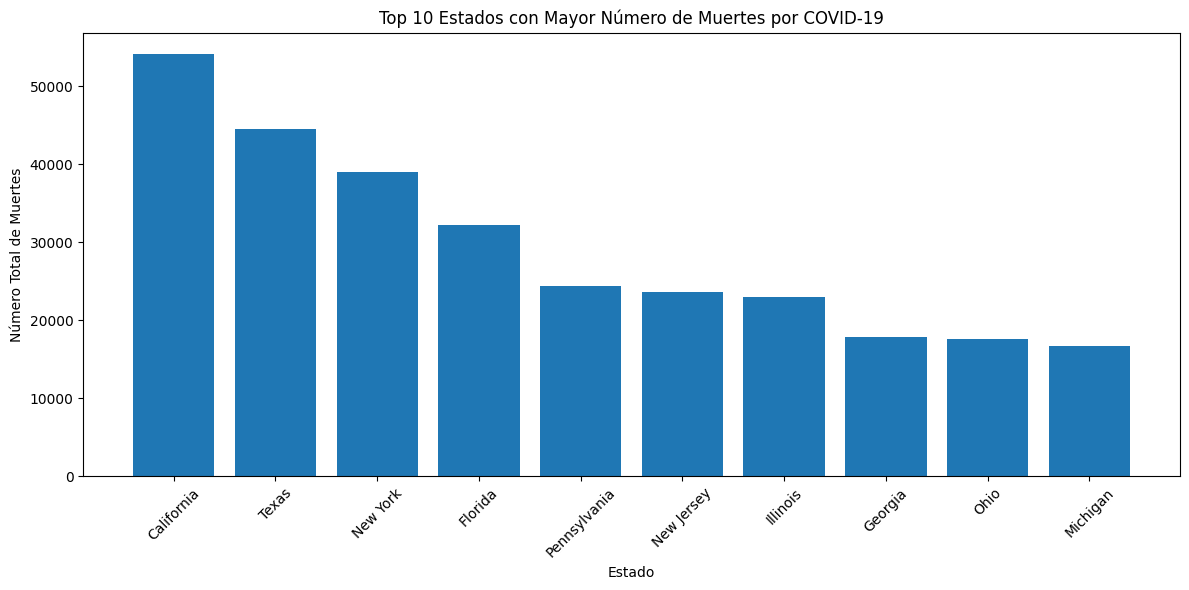

<ipython-input-15-1f5414b83e2c>:65: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



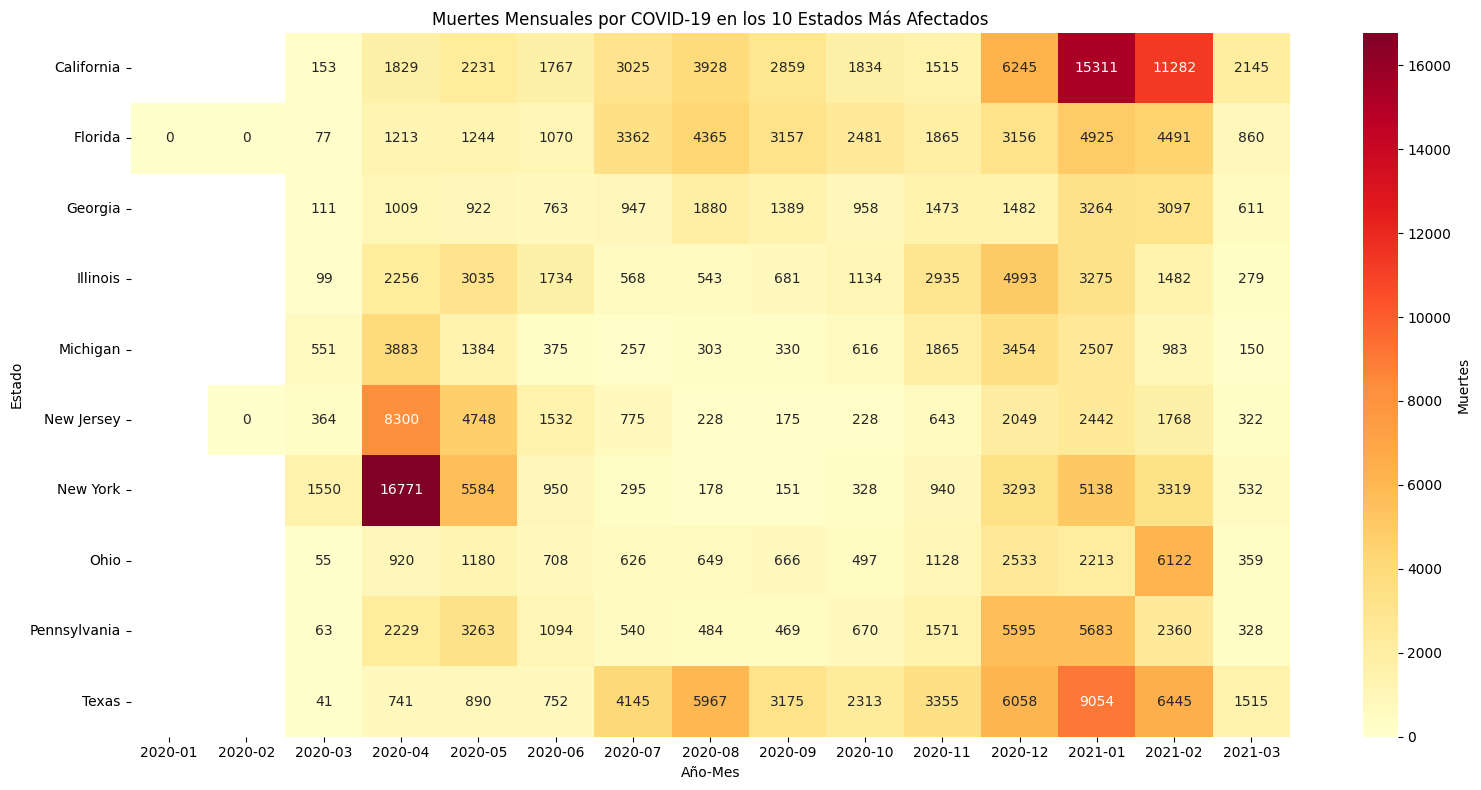

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime

# Obtener los datos de la API
url = "https://api.covidtracking.com/v1/states/daily.json"
response = requests.get(url)
data = response.json()

# Convertir a DataFrame
df = pd.DataFrame(data)

# Convertir la fecha a formato datetime
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

# Agregar columnas para mes y año
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Cargar el diccionario de estados
states_dict = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
    'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
    'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa',
    'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri',
    'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey',
    'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio',
    'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
    'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont',
    'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'
}

# Reemplazar abreviaturas por nombres completos de estados
df['state'] = df['state'].map(states_dict)

# Agrupar por estado, año y mes, y calcular la suma de muertes
monthly_deaths = df.groupby(['state', 'year', 'month'])['deathIncrease'].sum().reset_index()

# Encontrar el mes con más muertes para cada estado
max_deaths_by_state = monthly_deaths.loc[monthly_deaths.groupby('state')['deathIncrease'].idxmax()]

# Ordenar los estados por número total de muertes
state_total_deaths = df.groupby('state')['deathIncrease'].sum().sort_values(ascending=False)

# 1. Gráfico de barras para los 10 estados con más muertes (Matplotlib)
plt.figure(figsize=(12, 6))
top_10_states = state_total_deaths.head(10)
plt.bar(top_10_states.index, top_10_states.values)
plt.title('Top 10 Estados con Mayor Número de Muertes por COVID-19')
plt.xlabel('Estado')
plt.ylabel('Número Total de Muertes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Mapa de calor de muertes mensuales para los 10 estados más afectados (Seaborn)
top_10_states = state_total_deaths.head(10).index
top_10_monthly_deaths = monthly_deaths[monthly_deaths['state'].isin(top_10_states)]

# Crear una columna combinada de año y mes para evitar duplicados
top_10_monthly_deaths['year_month'] = top_10_monthly_deaths['year'].astype(str) + '-' + top_10_monthly_deaths['month'].astype(str).str.zfill(2)

pivot_data = top_10_monthly_deaths.pivot(index='state', columns='year_month', values='deathIncrease')

plt.figure(figsize=(16, 8))
sns.heatmap(pivot_data, cmap='YlOrRd', annot=True, fmt='.0f', cbar_kws={'label': 'Muertes'})
plt.title('Muertes Mensuales por COVID-19 en los 10 Estados Más Afectados')
plt.xlabel('Año-Mes')
plt.ylabel('Estado')
plt.tight_layout()
plt.show()

# 3. Gráfico de líneas para la evolución de muertes en los 5 estados más afectados (Plotly)
top_5_states = state_total_deaths.head(5).index
top_5_data = df[df['state'].isin(top_5_states)]

fig = px.line(top_5_data, x='date', y='death', color='state',
              title='Evolución de Muertes por COVID-19 en los 5 Estados Más Afectados',
              labels={'date': 'Fecha', 'death': 'Muertes Acumuladas', 'state': 'Estado'})
fig.show()

# 4. Gráfico de burbujas para el mes con más muertes por estado (Plotly)
fig = px.scatter(max_deaths_by_state, x='month', y='deathIncrease', size='deathIncrease', color='state',
                 hover_name='state', size_max=60,
                 title='Mes con Mayor Número de Muertes por COVID-19 en Cada Estado',
                 labels={'month': 'Mes', 'deathIncrease': 'Número de Muertes', 'state': 'Estado'})
fig.show()

# Imprimir los resultados
#print("Meses con mayor incidencia de muertes por COVID-19 en cada estado:")
#for _, row in max_deaths_by_state.iterrows():
    #state = row['state']
    #year = row['year']
    #month = row['month']
    #deaths = row['deathIncrease']
    #print(f"{state}: {datetime(year, month, 1).strftime('%B %Y')} - {deaths:.0f} muertes")


# 1. Mapa de calor de hospitalizaciones por estado y mes
df['month_year'] = df['date'].dt.to_period('M').astype(str)  # Convertir a string
heatmap_data = df.groupby(['state', 'month_year'])['hospitalizedCurrently'].mean().unstack()

fig1 = px.imshow(heatmap_data,
                 labels=dict(x="Mes", y="Estado", color="Hospitalizaciones promedio"),
                 title="Mapa de calor de hospitalizaciones por COVID-19 por estado y mes")
fig1.update_xaxes(side="top")
#fig1.show()

# 2. Gráfico de líneas de hospitalizaciones para los 10 estados más afectados
top_10_states = df.groupby('state')['hospitalizedCurrently'].max().nlargest(10).index

fig2 = go.Figure()
for state in top_10_states:
    state_data = df[df['state'] == state].groupby('month_year')['hospitalizedCurrently'].mean()
    fig2.add_trace(go.Scatter(x=state_data.index, y=state_data.values, name=state, mode='lines+markers'))

fig2.update_layout(title="Hospitalizaciones mensuales en los 10 estados más afectados",
                   xaxis_title="Mes",
                   yaxis_title="Hospitalizaciones promedio")
fig2.show()



# Gráficos parte 2

In [ ]:
#I add here the graphic libraries to be used later

import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

all_states_data = []

# List of all U.S. state abbreviations
states = [
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN',
    'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV',
    'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN',
    'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'
]

# Mapping state abbreviations to full names
state_name_mapping = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas',
    'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware',
    'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho',
    'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas',
    'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi',
    'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada',
    'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York',
    'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma',
    'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
    'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah',
    'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia',
    'WI': 'Wisconsin', 'WY': 'Wyoming', 'DC': 'District of Columbia',
    'AS': 'American Samoa', 'GU': 'Guam', 'MP': 'Northern Mariana Islands',
    'PR': 'Puerto Rico', 'VI': 'Virgin Islands'
}

# Grouping states and territories into 5 buckets
state_group_mapping = {
    'AL': 'South', 'AK': 'West', 'AZ': 'West', 'AR': 'South',
    'CA': 'West', 'CO': 'West', 'CT': 'Northeast', 'DE': 'South',
    'FL': 'South', 'GA': 'South', 'HI': 'West', 'ID': 'West',
    'IL': 'Midwest', 'IN': 'Midwest', 'IA': 'Midwest', 'KS': 'Midwest',
    'KY': 'South', 'LA': 'South', 'ME': 'Northeast', 'MD': 'South',
    'MA': 'Northeast', 'MI': 'Midwest', 'MN': 'Midwest', 'MS': 'South',
    'MO': 'Midwest', 'MT': 'West', 'NE': 'Midwest', 'NV': 'West',
    'NH': 'Northeast', 'NJ': 'Northeast', 'NM': 'West', 'NY': 'Northeast',
    'NC': 'South', 'ND': 'Midwest', 'OH': 'Midwest', 'OK': 'South',
    'OR': 'West', 'PA': 'Northeast', 'RI': 'Northeast', 'SC': 'South',
    'SD': 'Midwest', 'TN': 'South', 'TX': 'South', 'UT': 'West',
    'VT': 'Northeast', 'VA': 'South', 'WA': 'West', 'WV': 'South',
    'WI': 'Midwest', 'WY': 'West', 'DC': 'South',
    'AS': 'Territories', 'GU': 'Territories', 'MP': 'Territories',
    'PR': 'Territories', 'VI': 'Territories'
}

# Function to fetch data for a single state
def fetch_state_data(state):
    url = f"https://api.covidtracking.com/v2/states/{state}/daily/simple.json"
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()

        # Extract the 'data' field which contains the relevant information
        if 'data' in data:
            return pd.json_normalize(data['data'])  # Flatten nested data
        else:
            print(f"No data found for state {state}")
            return pd.DataFrame()

    except requests.exceptions.RequestException as e:
        print(f"Failed to fetch data for state {state}: {e}")
        return pd.DataFrame()  # Return an empty DataFrame on error


# List comprehension to fetch data and filter out empty or all-NA DataFrames
fetched_data = [fetch_state_data(state.lower()) for state in states]

# Filter out empty or all-NA DataFrames
filtered_data = [df for df in fetched_data if not df.empty and not df.isna().all().all()]

# Concatenate the filtered DataFrames into a single one
all_states_data = pd.concat(filtered_data, ignore_index=True)

# Adding columns to the DataFrame
all_states_data['state_name'] = all_states_data['state'].map(state_name_mapping)
all_states_data['region'] = all_states_data['state'].map(state_group_mapping)

# Ensure the date column is in datetime format
all_states_data['date'] = pd.to_datetime(all_states_data['date'])

# Add the week, month, quarter, and year columns
all_states_data['week'] = all_states_data['date'].dt.isocalendar().week
all_states_data['month'] = all_states_data['date'].dt.month
all_states_data['quarter'] = all_states_data['date'].dt.quarter
all_states_data['year'] = all_states_data['date'].dt.year


#Adding delta tables

# Ensure the dataframe is sorted by date for each state
all_states_data = all_states_data.sort_values(by=['state', 'date'])

# List of columns to calculate deltas for
columns_to_diff = [
    'cases.total', 'cases.confirmed', 'cases.probable',
    'tests.pcr.total', 'tests.pcr.encounters.total', 'tests.pcr.specimens.total',
    'tests.pcr.specimens.positive', 'tests.pcr.specimens.negative', 'tests.pcr.people.total',
    'tests.pcr.people.positive', 'tests.pcr.people.negative',
    'tests.antibody.encounters.total', 'tests.antibody.encounters.positive', 'tests.antibody.encounters.negative',
    'tests.antibody.people.total', 'tests.antibody.people.positive', 'tests.antibody.people.negative',
    'tests.antigen.encounters.total', 'tests.antigen.encounters.positive', 'tests.antigen.encounters.negative',
    'tests.antigen.people.total', 'tests.antigen.people.positive', 'tests.antigen.people.negative',
    'outcomes.recovered', 'outcomes.hospitalized.total', 'outcomes.hospitalized.currently',
    'outcomes.hospitalized.in_icu.total', 'outcomes.hospitalized.in_icu.currently',
    'outcomes.hospitalized.on_ventilator.total', 'outcomes.hospitalized.on_ventilator.currently',
    'outcomes.death.total', 'outcomes.death.confirmed', 'outcomes.death.probable'
]

# Calculate the delta for each column
for col in columns_to_diff:
    delta_col_name = f"{col}_delta"
    all_states_data[delta_col_name] = all_states_data.groupby('state')[col].diff()

# Display the first few rows of the updated dataframe to verify the new columns
#print(all_states_data[['date', 'state'] + [f"{col}_delta" for col in columns_to_diff]].head(10))

# Save the data to a CSV file for future use
#all_states_data.to_csv('covid_tracking_all_states.csv', index=False) #Comentado una vez que se obtuvo el fichero

# Display the first few rows of the combined DataFrame
#all_states_data.head()

# Display the updated dataframe
#print(all_states_data[['date', 'week', 'month', 'quarter', 'year']].head())

# Set the style for seaborn
sns.set_theme(style="whitegrid")

<ipython-input-1-cc764bcea5a0>:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_states_data = pd.concat(filtered_data, ignore_index=True)


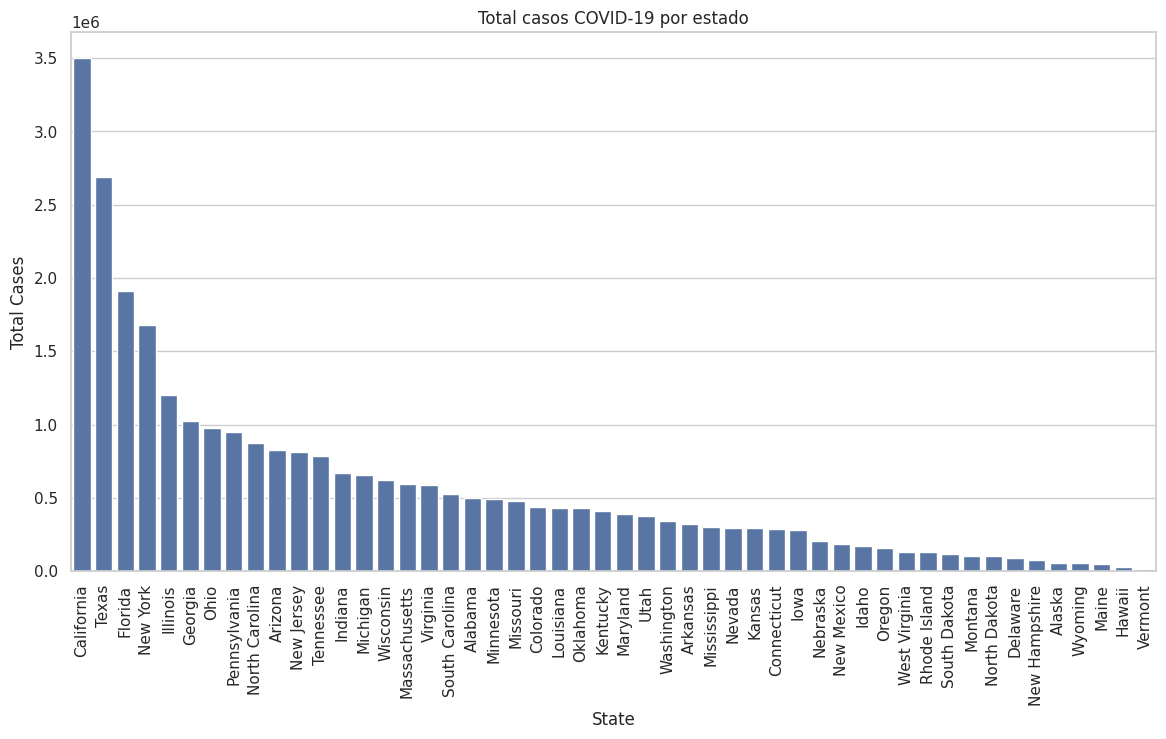

In [ ]:
# Group data by state and sum the total cases
state_cases = all_states_data.groupby('state_name')['cases.total'].max().reset_index()

# Plot the total number of cases across states
plt.figure(figsize=(14, 7))
sns.barplot(x='state_name', y='cases.total', data=state_cases.sort_values('cases.total', ascending=False))
plt.xlabel('State')
plt.ylabel('Total Cases')
plt.title('Total casos COVID-19 por estado')
plt.xticks(rotation=90)
plt.show()


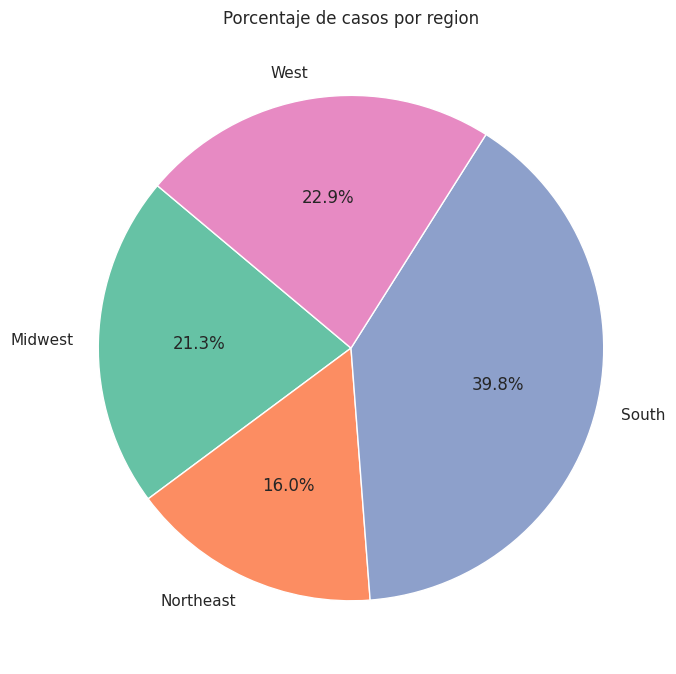

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Grouping by region and summing the deltas
region_cases_delta = all_states_data.groupby('region')['cases.total_delta'].sum()

# Create a single subplot for the pie chart
fig, ax = plt.subplots(figsize=(7, 7))

# Pie chart for cases.total_delta by region
ax.pie(region_cases_delta, labels=region_cases_delta.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set2"))
ax.set_title('Porcentaje de casos por region')

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import plotly.express as px

# Group by state and sum the cases.total_delta
state_cases_delta = all_states_data.groupby('state')['cases.total_delta'].sum().reset_index()

# Create the choropleth map
fig = px.choropleth(state_cases_delta,
                    locations='state',
                    locationmode='USA-states',
                    color='cases.total_delta',
                    color_continuous_scale="Viridis",
                    scope="usa",
                    labels={'cases.total_delta':'Cases Delta'},
                    title='Casos Totales por Estado')

# Show the map
fig.show()


In [ ]:
# Hospitalizaciones y fallecimientos por region

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact

# Function to plot data for a selected state
def plot_state_trends(reg_name):
    # Filter data by quality grade and state
    quality_grades = ['A', 'A+', 'B', 'C']
    filtered_data = all_states_data[(all_states_data['meta.data_quality_grade'].isin(quality_grades)) &
                                    (all_states_data['region'] == reg_name)]

    # Ensure the DataFrame is sorted by date
    filtered_data = filtered_data.sort_values(by='date')

    # List of delta columns to sum
    delta_columns = [
        'outcomes.hospitalized.total_delta',
        #'outcomes.hospitalized.in_icu.total_delta',
        #'outcomes.hospitalized.on_ventilator.total_delta',
        'outcomes.death.total_delta'
    ]

    # Sum the delta columns across the selected state for each date
    summed_data = filtered_data.groupby('date')[delta_columns].sum().reset_index()

    # Apply a 14-day moving average to smooth the trends
    for col in delta_columns:
        summed_data[f'{col}_ma'] = summed_data[col].rolling(window=14).mean()

    # Plotting the trend lines
    plt.figure(figsize=(14, 8))
    sns.set_theme(style="whitegrid")

    # Plot each smoothed delta trend line
    for col in delta_columns:
        plt.plot(summed_data['date'], summed_data[f'{col}_ma'], label=col.replace('_delta', '').replace('outcomes.', '').replace('.', ' ').title())

    # Customize the plot
    plt.title(f'14-Day Moving Average of Key COVID-19 Metrics Over Time in {reg_name} (Data Quality Grade A, A+, B or C)')
    plt.xlabel('Date')
    plt.ylabel('14-Day Moving Average')
    plt.legend(title='Metric')
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Show the plot
    plt.show()

# List of states available in the dataset
regions = all_states_data['region'].unique()

# Create an interactive widget for state selection
interact(plot_state_trends, reg_name=regions)


interactive(children=(Dropdown(description='reg_name', options=('West', 'South', 'Northeast', 'Midwest'), valu…

<function __main__.plot_state_trends(reg_name)>

In [ ]:
# Hospitalizaciones y fallecimientos por estado

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact

# Function to plot data for a selected state
def plot_state_trends(state):
    # Filter data by quality grade and state
    quality_grades = ['A', 'A+', 'B', 'C']
    filtered_data = all_states_data[(all_states_data['meta.data_quality_grade'].isin(quality_grades)) &
                                    (all_states_data['state_name'] == state)]

    # Ensure the DataFrame is sorted by date
    filtered_data = filtered_data.sort_values(by='date')

    # List of delta columns to sum
    delta_columns = [
        'outcomes.hospitalized.total_delta',
        #'outcomes.hospitalized.in_icu.total_delta',
        #'outcomes.hospitalized.on_ventilator.total_delta',
        'outcomes.death.total_delta'
    ]

    # Sum the delta columns across the selected state for each date
    summed_data = filtered_data.groupby('date')[delta_columns].sum().reset_index()

    # Apply a 14-day moving average to smooth the trends
    for col in delta_columns:
        summed_data[f'{col}_ma'] = summed_data[col].rolling(window=14).mean()

    # Plotting the trend lines
    plt.figure(figsize=(14, 8))
    sns.set_theme(style="whitegrid")

    # Plot each smoothed delta trend line
    for col in delta_columns:
        plt.plot(summed_data['date'], summed_data[f'{col}_ma'], label=col.replace('_delta', '').replace('outcomes.', '').replace('.', ' ').title())

    # Customize the plot
    plt.title(f'14-Day Moving Average of Key COVID-19 Metrics Over Time in {state} (Data Quality Grade A, A+, B or C)')
    plt.xlabel('Date')
    plt.ylabel('14-Day Moving Average')
    plt.legend(title='Metric')
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Show the plot
    plt.show()

# List of states available in the dataset
states = all_states_data['state_name'].unique()

# Create an interactive widget for state selection
interact(plot_state_trends, state=states)


interactive(children=(Dropdown(description='state', options=('Alaska', 'Alabama', 'Arkansas', 'Arizona', 'Cali…

<function __main__.plot_state_trends(state)>

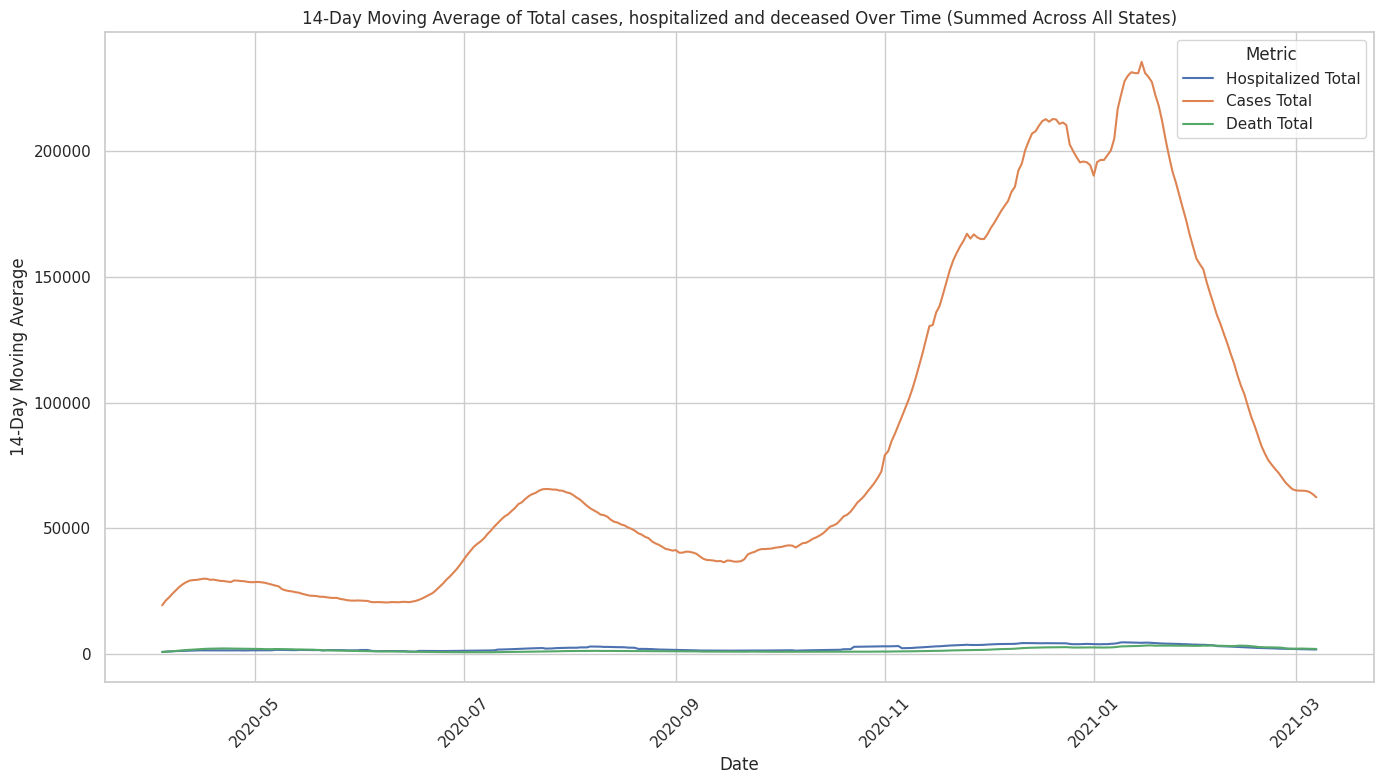

In [ ]:
# Contagios, Hospitlizaciones y fallecimientos total USA

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data by quality grade
quality_grades = ['A', 'A+', 'B', 'C']
filtered_data = all_states_data[all_states_data['meta.data_quality_grade'].isin(quality_grades)]

# Ensure the DataFrame is sorted by date
filtered_data = filtered_data.sort_values(by='date')

# List of delta columns to sum
delta_columns = [
    'outcomes.hospitalized.total_delta',
    'cases.total_delta',
    #'outcomes.hospitalized.on_ventilator.total_delta',
    'outcomes.death.total_delta'#,
    #'outcomes.recovered_delta'
]

# Sum the delta columns across all states for each date
summed_data = filtered_data.groupby('date')[delta_columns].sum().reset_index()

# Apply a 14-day moving average to smooth the trends
for col in delta_columns:
    summed_data[f'{col}_ma'] = summed_data[col].rolling(window=14).mean()

# Plotting the trend lines
plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

# Plot each smoothed delta trend line
for col in delta_columns:
    plt.plot(summed_data['date'], summed_data[f'{col}_ma'], label=col.replace('_delta', '').replace('outcomes.', '').replace('.', ' ').title())

# Customize the plot
plt.title('14-Day Moving Average of Total cases, hospitalized and deceased Over Time (Summed Across All States)')
plt.xlabel('Date')
plt.ylabel('14-Day Moving Average')
plt.legend(title='Metric')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


## **Algorítimo para manejo de Outliers y Datos Nulos**

### **Conjunto de Datos Elegido para el EDA**

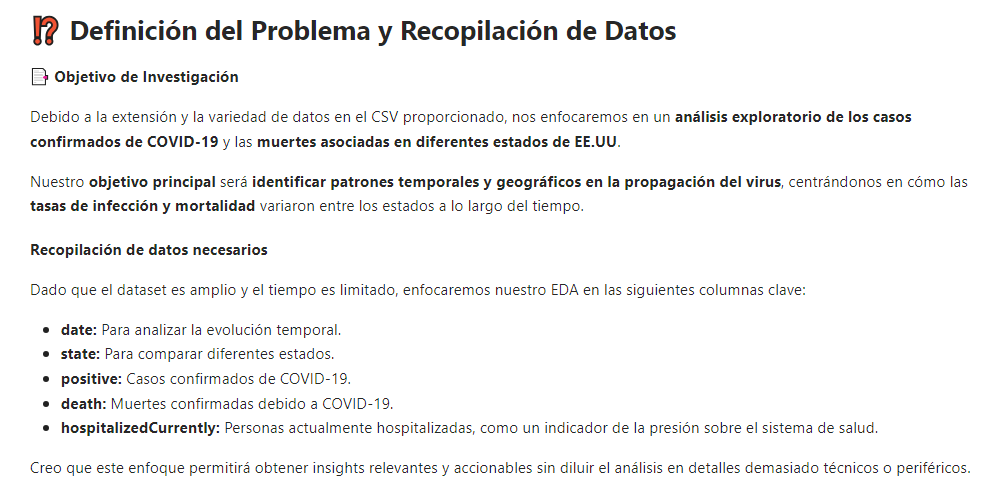

## **Problemas Detectados en este conjunto de Datos**

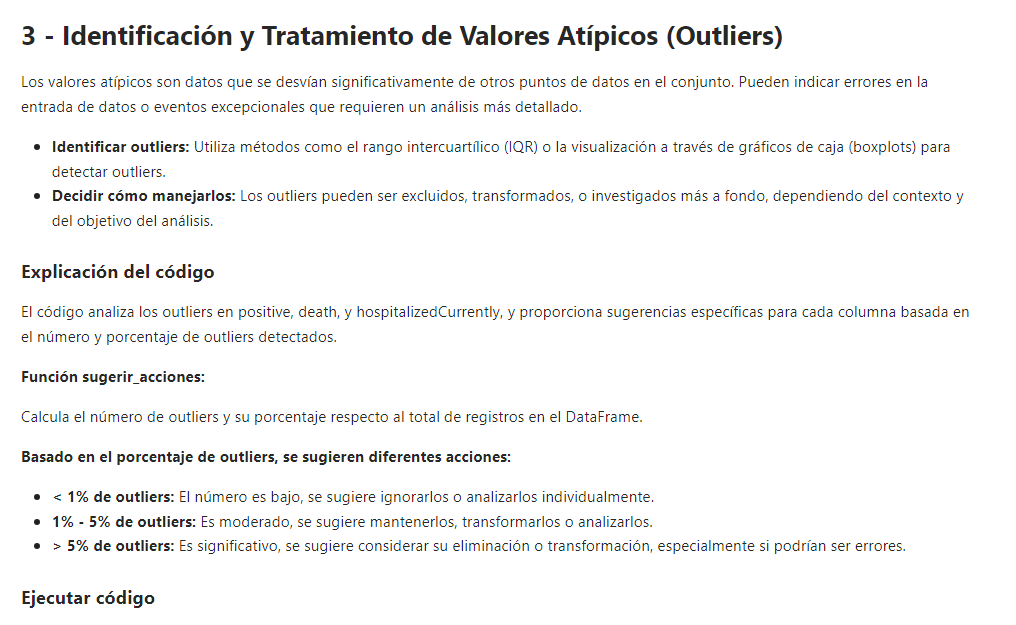

### **->Diagnóstico de los Outliers despues de ejecutado el código**

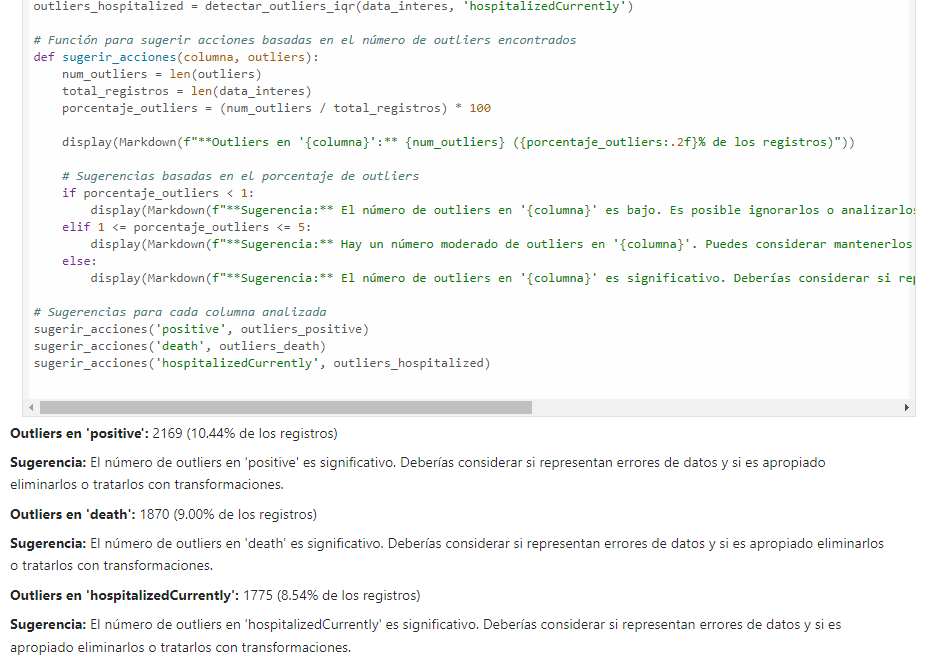

### **->Verificación de valores nulos en el conjunto de datos**

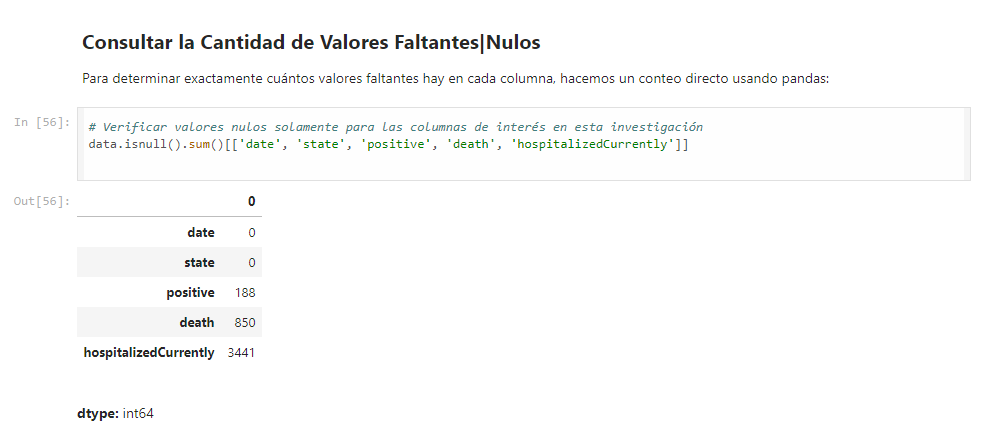

## **Código generación automática para Diagnóstico para Tratamiento de Datos Nulos**

El objetivo del código es determinar si los datos en columnas con valores nulos están distribuidos normalmente o no, y luego sugerir la mejor manera de tratar esos valores nulos (imputación por media, mediana, moda, o eliminación de filas).

Para hacer esto, el código utiliza diferentes pruebas de normalidad según el tamaño de la muestra y las características de la distribución de los datos  (tamaño de la muestra y sesgo).

 -> **Pruebas Usadas:**

**Prueba de Shapiro-Wilk:**
- **Uso:** Esta prueba se usa cuando el tamaño de la **muestra es pequeño (N ≤ 5000)** y no hay un sesgo significativo en los datos.
- **Propósito:** Detectar si los datos están normalmente distribuidos.
- **Resultado:** Devuelve True si los datos son normales, y False si no lo son.

**Prueba de Anderson-Darling:**
- **Uso:** Se utiliza cuando la **muestra es pequeña (N ≤ 5000)** pero se detecta un sesgo significativo en los datos (skewness > 0.5).
- **Propósito:** Detectar si los datos siguen una distribución normal, con mayor sensibilidad en las colas (extremos) de la distribución.
- **Resultado:** Devuelve True si los datos son normales, basándose en el estadístico de la prueba comparado con los valores críticos.

**Prueba de Kolmogorov-Smirnov (K-S):**
- **Uso:** Se utiliza para **muestras grandes (N > 5000)**.
- **Propósito:** Comparar la distribución de los datos con una distribución normal de referencia.
- **Resultado:** Devuelve True si los datos son normales, basado en el p-valor de la prueba.

-> **Pasos ejecutados en el código:**

1. **Cálculo del Porcentaje de Valores Faltantes:**
Este código calcula el porcentaje de valores faltantes para cada columna en el DataFrame data_interes. Esto es importante para determinar si se debe imputar o eliminar filas con valores nulos.

2. **Función (check_distribution(column)) para Verificar la Normalidad de los Datos:**
La función es clave para evaluar si los datos están distribuidos normalmente y decide automáticamente qué prueba de normalidad utilizar.

3. **Sugerir el Mejor Método de Imputación:**
Una vez que se determina si los datos son normales o no, la función suggest_imputation_method sugiere el método de imputación más adecuado:
- **Media:** Se sugiere si los datos están normalmente distribuidos.
- **Mediana:** Se sugiere si los datos no están normalmente distribuidos o presentan sesgo.
- **Moda:** Se sugiere para datos categóricos.
- **Métodos avanzados:** Se consideran si las columnas son complejas y podrían beneficiarse de técnicas más sofisticadas.

#### Resultado del diagnóticos de valores nulos en las variables de interés

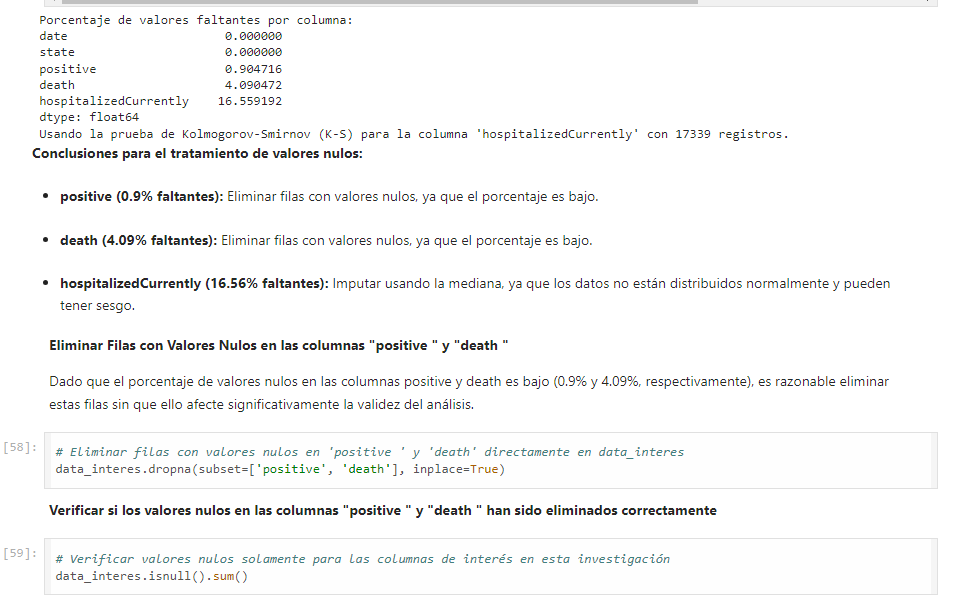